# Packages and settings

In [1]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'matplotlib.pyplot', 'datetime', 'scipy.optimize', 'seaborn', 'sqlite3']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np                                  # For numerical computing
import pandas as pd                                 # For data manipulation
import seaborn as sns                               # For statistical data visualization
import matplotlib.pyplot as plt                     # For plotting
import datetime as dt                               # For datetime operations 
import warnings
import sqlite3

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark-palette')

# Importing data

For the BAB factor, since we are using a rolling approch, we will include the data all the way back to 1980 to compute some values, but will use the filters on price and market cap.

In [2]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

### Reading the data from the database
ret_d = pd.read_sql('SELECT * FROM filtered_daily_returns', conn).set_index('Date')
ret_m = pd.read_sql('SELECT * FROM filtered_monthly_returns', conn).set_index('Date')
factors_d = pd.read_sql('SELECT * FROM factors_daily', conn).set_index('date')
factors_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('date')

### Closing the connection
conn.close()

In [3]:
### Making sure the index is a datetime index
ret_d.index = pd.to_datetime(ret_d.index)
ret_m.index = pd.to_datetime(ret_m.index)
factors_d.index = pd.to_datetime(factors_d.index)
factors_m.index = pd.to_datetime(factors_m.index)

### Dropping columns with less then 4 months of data
ret_m = ret_m.dropna(axis=1, thresh=4)
ret_d = ret_d[ret_m.columns]

Due to our stocks starting in 1980 and our risk-free ending in the beginning of 2024, we will restrict our dataperiod to 1980-2023.

I also will create excess returns. All factors are already excess, but the Value-Weigted (VW), Equally-Wwighted (EW) and the stock returns are not.

In [4]:
### Restricting the data to 1980-2023
ret_d = ret_d.loc['1980':'2023']
ret_m = ret_m.loc['1980':'2023']
factors_d = factors_d.loc['1980':'2023']
factors_m = factors_m.loc['1980':'2023']

### Creating excess returns
# Stocks
exc_ret_d = ret_d.sub(factors_d['rf'], axis=0)
exc_ret_m = ret_m.sub(factors_m['rf'], axis=0)

# VW
exc_vw_ret_d = factors_d['VW'].sub(factors_d['rf'], axis=0)
exc_vw_ret_m = factors_m['VW'].sub(factors_m['rf'], axis=0)

# EW
exc_ew_ret_d = factors_d['EW'].sub(factors_d['rf'], axis=0)
exc_ew_ret_m = factors_m['EW'].sub(factors_m['rf'], axis=0)

### Turning the retuns into log returns
log_ret_d = np.log(1 + ret_d)
log_ret_m = np.log(1 + ret_m)
log_exc_ret_d = np.log(1 + exc_ret_d)
log_exc_ret_m = np.log(1 + exc_ret_m)
log_exc_vw_ret_d = np.log(1 + exc_vw_ret_d)
log_exc_vw_ret_m = np.log(1 + exc_vw_ret_m)
log_exc_ew_ret_d = np.log(1 + exc_ew_ret_d)
log_exc_ew_ret_m = np.log(1 + exc_ew_ret_m)
log_factors_d = np.log(1 + factors_d)
log_factors_m = np.log(1 + factors_m)

# Recreating BAB

Code is inspired from: 

- https://github.com/WenqiAngieWu/Betting-Against-Beta/blob/master/main.py

- "The Robustness of Betting Against Beta: Implications of Portfolio Weights and Skewness Risk", reference is found in the thesis.

### Taking care of daily data

In [5]:
### Checking how many were removed
print(factors_d.shape)
print(ret_d.shape)
print(exc_ret_d.shape)
print(exc_vw_ret_d.shape)
print(exc_ew_ret_d.shape)
print('')

### Extracting the dates that overlap from factors_daily and returns_daily
dates = list(set(factors_d.index).intersection(ret_d.index))

### Creating a new dataframe with the dates that overlap
factors_d = factors_d.loc[dates]
ret_d = ret_d.loc[dates]
exc_ret_d = exc_ret_d.loc[dates]
exc_vw_ret_d = exc_vw_ret_d.loc[dates]
exc_ew_ret_d = exc_ew_ret_d.loc[dates]

### Checking how many were removed
print(factors_d.shape)
print(ret_d.shape)
print(exc_ret_d.shape)
print(exc_vw_ret_d.shape)
print(exc_ew_ret_d.shape)

(11102, 6)
(11041, 1204)
(11102, 1204)
(11102,)
(11102,)

(11041, 6)
(11041, 1204)
(11041, 1204)
(11041,)
(11041,)


### Taking care of monthly data

In [6]:
### Checking how many were removed
print(factors_m.shape)
print(ret_m.shape)
print(exc_vw_ret_m.shape)
print(exc_ew_ret_m.shape)
print('')

### Extracting the dates that overlap from factors_monthly and returns_monthly
dates = list(set(factors_m.index).intersection(ret_m.index))

### Creating a new dataframe with the dates that overlap
factors_m = factors_m.loc[dates]
ret_m = ret_m.loc[dates]
exc_ret_m = exc_ret_m.loc[dates]
exc_vw_ret_m = exc_vw_ret_m.loc[dates]
exc_ew_ret_m = exc_ew_ret_m.loc[dates]

### Checking how many were removed
print(factors_m.shape)
print(ret_m.shape)
print(exc_vw_ret_m.shape)
print(exc_ew_ret_m.shape)

(528, 6)
(528, 1204)
(528,)
(528,)

(528, 6)
(528, 1204)
(528,)
(528,)


### Beta estimations

In [7]:
### Getting the 3 day log returns
log_exc_ret_d_3 = log_exc_ret_d.rolling(window=3).sum()
log_exc_vw_ret_d_3 = log_exc_vw_ret_d.rolling(window=3).sum()


### Getting the volatility as a rolling 250 day standard deviation
# We will need at least 120 values to get the first value
roll_vol = lambda x: x.rolling(window=252, closed='left', min_periods=120).std()
vol_d = log_exc_ret_d.apply(roll_vol, axis=0)
vol_vw_d = log_exc_vw_ret_d.rolling(window=252, closed='left', min_periods=120).std()

### Getting the correlations
# We will need at least 50 values to get the first value
roll_corr = lambda x: x.rolling(window=252*5, closed='left', min_periods=750).corr(log_exc_vw_ret_d_3)
corr_d = log_exc_ret_d_3.apply(roll_corr, axis=0)

### Dropping invalid values
idx = vol_d.index.intersection(vol_vw_d.index).intersection(corr_d.index)
vol_d = vol_d.loc[idx]
vol_vw_d = vol_vw_d.loc[idx]
corr_d = corr_d.loc[idx]

### Getting the betas
betaDaily = 0.6 * corr_d.mul(vol_d, axis=0).apply(lambda x: x.div(vol_vw_d), axis=0) + 0.4
betaMonthly = betaDaily.resample('M').last()
betaMonthly

,2020,5PG,AASB,AAT,AAV,ABG,ABL,ABS,ABT,ABTEC,...,WWL,XPLRA,XXL,YAR,ZAL,ZAP,ZENA,ZENT,ZONC,ZWIPE
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.955958,0.631007,NaN,NaN,NaN,0.714419,NaN,NaN,0.826540,NaN,...,NaN,NaN,1.288043,0.892543,0.789409,NaN,0.622632,NaN,NaN,0.618767
2023-09-30,0.994847,0.662565,NaN,NaN,NaN,0.744355,NaN,NaN,0.847162,NaN,...,NaN,NaN,1.355270,0.909235,0.816447,NaN,0.645078,NaN,NaN,0.654003
2023-10-31,0.985837,0.640928,NaN,NaN,NaN,0.741482,NaN,NaN,NaN,NaN,...,NaN,NaN,1.666778,0.879602,0.813522,1.073837,0.649233,NaN,NaN,0.654726
2023-11-30,0.956097,0.586930,NaN,NaN,NaN,0.744234,NaN,NaN,NaN,NaN,...,NaN,NaN,1.626538,0.874991,0.829013,1.071900,0.671683,NaN,NaN,0.618094


In [8]:
### Getting the volatility as a rolling 250 day standard deviation
# We will need at least 6 values to get the first value
roll_vol = lambda x: x.rolling(window=12, closed='left', min_periods=6).std()
vol_m = log_exc_ret_m.apply(roll_vol, axis=0)
vol_vw_m = log_exc_vw_ret_m.rolling(window=12, closed='left', min_periods=6).std()

### Getting the correlations
# We will need at least 50 values to get the first value
roll_corr = lambda x: x.rolling(window=12*5, closed='left', min_periods=60).corr(log_exc_vw_ret_m)
corr_m = log_exc_ret_m.apply(roll_corr, axis=0)

### Dropping invalid values
idx = vol_m.index.intersection(vol_vw_m.index).intersection(corr_m.index)
vol_m = vol_m.loc[idx]
vol_vw_m = vol_vw_m.loc[idx]
corr_m = corr_m.loc[idx]

### Getting the betas
#betaMonthly = 0.6 * corr_m.mul(vol_m, axis=0).apply(lambda x: x.div(vol_vw_m), axis=0) + 0.4
#betaMonthly

Due to the closed='left' argument in the rolling command, the $\sigma_{t,i}$ and $\rho_{t,i}$ is based on returns from $t-251$ to $t-1$, making it unbiased. So the $\beta_{t,i}$ we have for time $t$ and stock $i$, can be used with the return in time $t$.

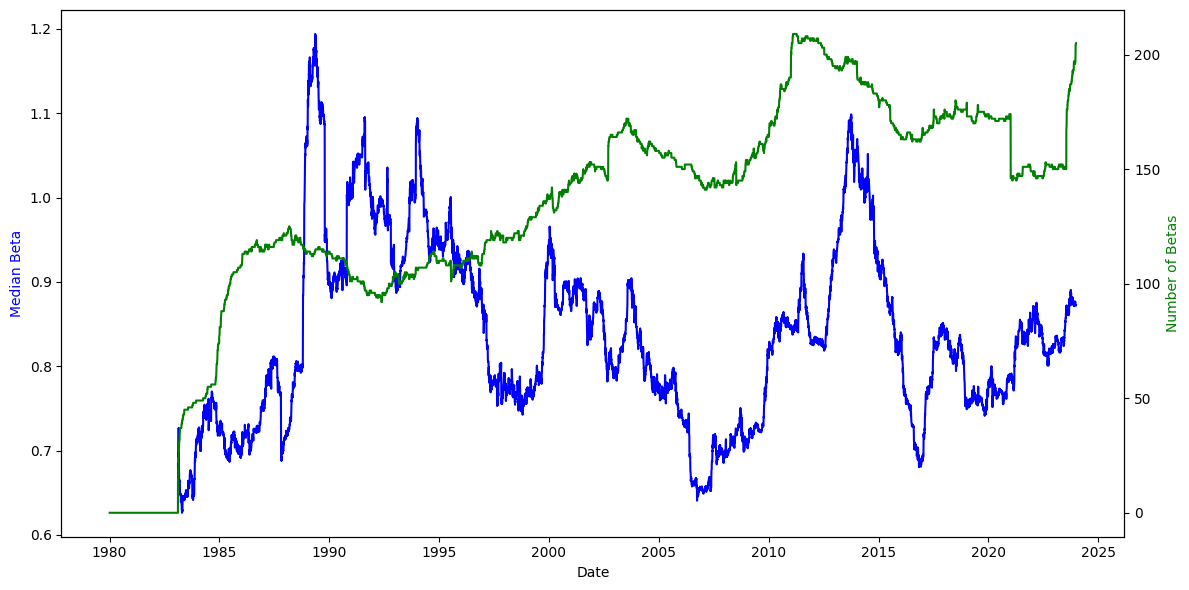

In [9]:
### Plotting the median beta value and the number of betas over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the median beta value
ax1.plot(betaDaily.median(axis=1), color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Median Beta', color='blue')
ax1.tick_params(axis='y')

# Creating a second y-axis to plot the number of betas
ax2 = ax1.twinx()
ax2.plot(betaDaily.notna().sum(axis=1), color='green')
ax2.set_ylabel('Number of Betas', color='green')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

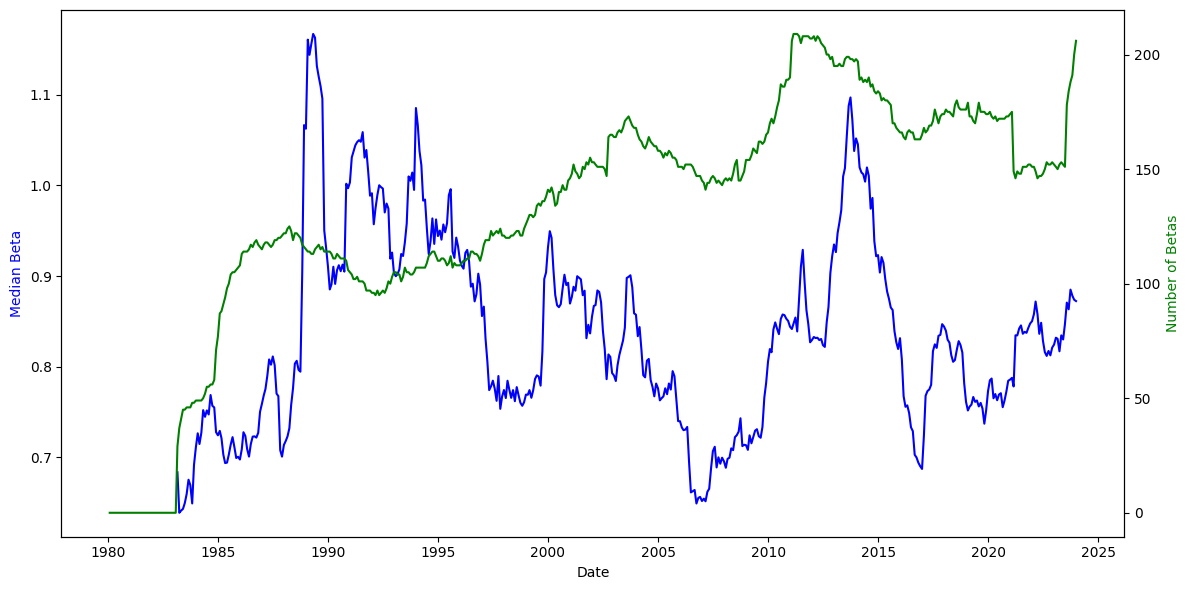

In [10]:
### Plotting the median beta value and the number of betas over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the median beta value
ax1.plot(betaMonthly.median(axis=1), color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Median Beta', color='blue')
ax1.tick_params(axis='y')

# Creating a second y-axis to plot the number of betas
ax2 = ax1.twinx()
ax2.plot(betaMonthly.notna().sum(axis=1), color='green')
ax2.set_ylabel('Number of Betas', color='green')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

### BaB - Daily rebalancing

In [15]:
w

,2020,5PG,AASB,AAT,AAV,ABG,ABL,ABS,ABT,ABTEC,...,WWL,XPLRA,XXL,YAR,ZAL,ZAP,ZENA,ZENT,ZONC,ZWIPE
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.006824,-0.017397,NaN,NaN,NaN,-0.009900,NaN,NaN,NaN,NaN,...,NaN,0.010285,0.018551,0.000481,-0.003172,0.010861,-0.013937,NaN,NaN,-0.016052
2023-12-22,0.006824,-0.017397,NaN,NaN,NaN,-0.009900,NaN,NaN,NaN,NaN,...,NaN,0.009900,0.018551,0.000481,-0.003172,0.010861,-0.013937,NaN,NaN,-0.016244
2023-12-27,0.006853,-0.017323,NaN,NaN,NaN,-0.009709,NaN,NaN,NaN,NaN,...,NaN,0.009899,0.018466,0.000381,-0.003046,0.010661,-0.013897,NaN,NaN,-0.016181
2023-12-28,0.006853,-0.017323,NaN,NaN,NaN,-0.009709,NaN,NaN,NaN,NaN,...,NaN,0.009899,0.018466,0.000000,-0.003046,0.010661,-0.013897,NaN,NaN,-0.016181


In [11]:
### Getting the beta rank
beta_rank_daily = betaDaily.rank(axis=1)

### Getting the median
median_daily = beta_rank_daily.mean(axis=1)

### Normalizing constant on each day
k_daily = 2 / abs(beta_rank_daily.subtract(median_daily, axis=0)).sum(axis=1)

### Getting the weights
w = beta_rank_daily.subtract(median_daily, axis=0).mul(k_daily, axis=0)
wH = w.applymap(lambda x:x if x > 0 else 0)
wL = w.applymap(lambda x:-x if x < 0 else 0)

### Getting the returns
ptf_bab_dailyL = (log_ret_d.sub(log_factors_d["rf"], axis=0).mul(wL, axis=1).sum(axis=1)) / (betaDaily.mul(wL, axis=1).sum(axis=1))
ptf_bab_dailyH = (log_ret_d.sub(log_factors_d["rf"], axis=0).mul(wH, axis=1).sum(axis=1)) / (betaDaily.mul(wH, axis=1).sum(axis=1))
ptf_bab_daily = ptf_bab_dailyL - ptf_bab_dailyH

### Removing all rows with NaN values
ptf_bab_daily = pd.DataFrame(ptf_bab_daily).dropna()

### Looking at the returns
ptf_bab_daily

,0
1983-02-11,0.024414
1983-02-14,-0.016543
1983-02-15,-0.051674
1983-02-16,-0.014348
1983-02-17,-0.031213
...,...
2023-12-21,-0.007054
2023-12-22,0.015390
2023-12-27,0.002506
2023-12-28,-0.005447


The sharpes ratio for BAB Daily is: 0.60
The sharpes ratio for BAB High Daily is: -0.48
The sharpes ratio for BAB Low Daily is: 0.21
The sharpes ratio for Market VW is: 0.93
The sharpes ratio for Market EW is: 0.92


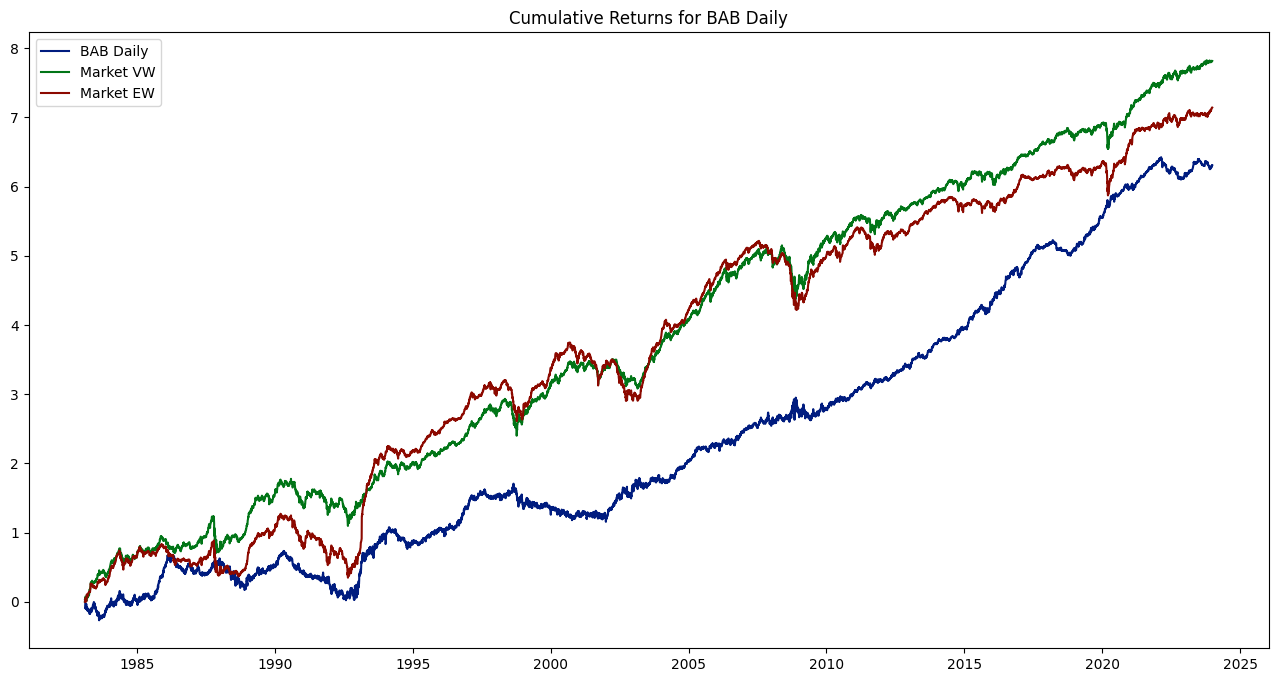

In [35]:
### Getting the index that is common to all
idx = ptf_bab_daily.index.intersection(ret_d.index)

### Sharpe ratios
print(f"The sharpes ratio for BAB Daily is: {(ptf_bab_daily.mean() / ptf_bab_daily.std() * np.sqrt(250)).item():.2f}")
print(f"The sharpes ratio for BAB High Daily is: {(ptf_bab_dailyH.mean() / ptf_bab_dailyH.std() * np.sqrt(250)).item():.2f}")
print(f"The sharpes ratio for BAB Low Daily is: {(ptf_bab_dailyL.mean() / ptf_bab_dailyL.std() * np.sqrt(250)).item():.2f}")
print(f"The sharpes ratio for Market VW is: {(exc_vw_ret_d.loc[idx].mean() / exc_vw_ret_d.loc[idx].std() * np.sqrt(250)).item():.2f}")
print(f"The sharpes ratio for Market EW is: {(exc_ew_ret_d.loc[idx].mean() / exc_ew_ret_d.loc[idx].std() * np.sqrt(250)).item():.2f}")

### Plotting cumulative returns for bab daily
plt.figure(figsize=(16,8))
plt.plot((ptf_bab_daily.loc[idx]).cumsum())
plt.plot((exc_vw_ret_d.loc[idx]).cumsum())
plt.plot((exc_ew_ret_d.loc[idx]).cumsum())
plt.legend(['BAB Daily', 'Market VW', 'Market EW'])
plt.title('Cumulative Returns for BAB Daily')
plt.show()

### BaB - Monthly rebalancing

In [36]:
### Turning the betas monthly
wMonthly = w.groupby(w.index.to_period('M')).tail(1)

### Fixing the idx
idx = ret_m.index
betaMonthly.index = idx
wMonthly.index = idx

### Getting the weights
#wMonthly = beta_rank_monthly.subtract(median_monthly, axis=0).mul(k_monthly, axis=0)
wMonthlyH = wMonthly.applymap(lambda x:x if x > 0 else 0)
wMonthlyL = wMonthly.applymap(lambda x:-x if x < 0 else 0)

### Getting the returns
ptf_bab_monthlyL = (log_ret_m.sub(log_factors_m['rf'], axis=0)).mul(wMonthlyL, axis=1).sum(axis=1) / (betaMonthly.mul(wMonthlyL, axis=1).sum(axis=1))
ptf_bab_monthlyH = (log_ret_m.sub(log_factors_m['rf'], axis=0)).mul(wMonthlyH, axis=1).sum(axis=1) / (betaMonthly.mul(wMonthlyH, axis=1).sum(axis=1))
ptf_bab_monthly = ptf_bab_monthlyL - ptf_bab_monthlyH

### Removing NaN values
ptf_bab_monthly = ptf_bab_monthly.dropna()

ptf_bab_monthly

Date
1980-01-31    0.003140
1980-02-29   -0.098197
1980-03-31    0.019669
1980-04-30    0.055506
1980-05-31   -0.046296
                ...   
2023-08-31    0.027806
2023-09-30   -0.015614
2023-10-31    0.002532
2023-11-30   -0.056881
2023-12-31    0.028252
Length: 491, dtype: float64

The sharpes ratio for BAB Monthly is: 0.47
The sharpes ratio for BAB High Monthly is: -0.38
The sharpes ratio for BAB Low Monthly is: 0.04
The sharpes ratio for Market VW is: 0.50
The sharpes ratio for Market EW is: 0.21


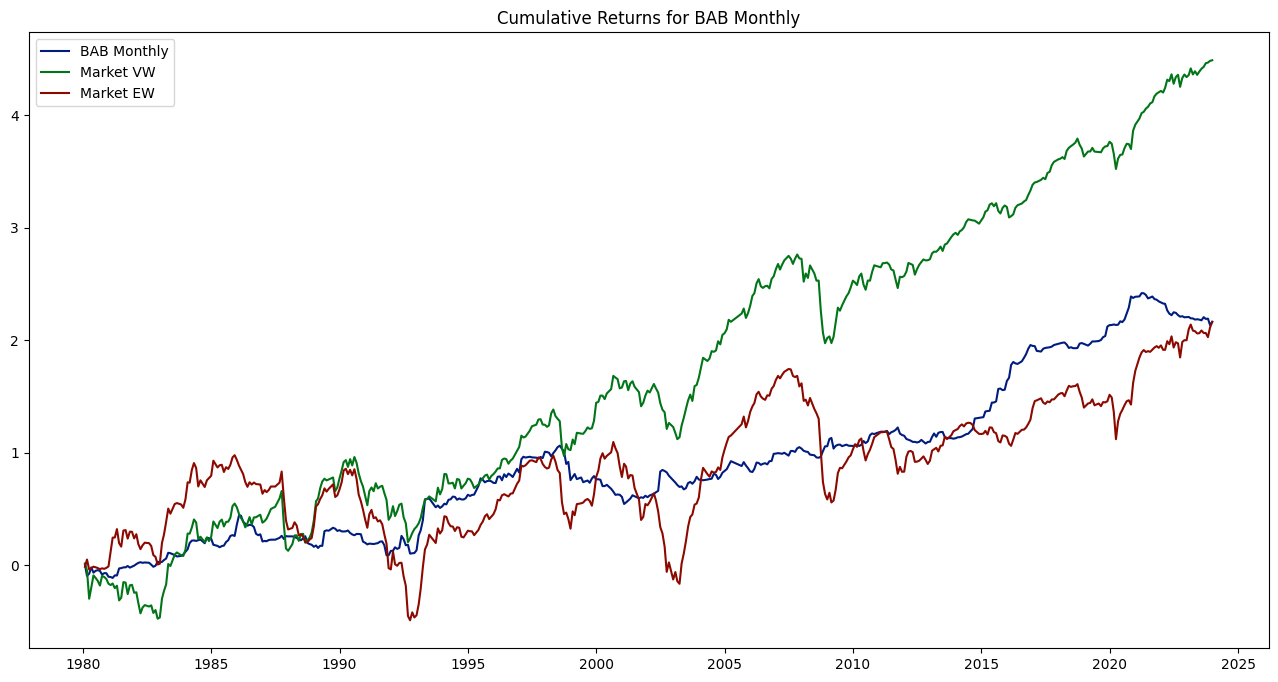

In [37]:
idx = ptf_bab_monthly.index 

### Sharpe ratios
print(f"The sharpes ratio for BAB Monthly is: {(ptf_bab_monthly.mean() / ptf_bab_monthly.std() * np.sqrt(12)).item():.2f}")
print(f"The sharpes ratio for BAB High Monthly is: {(ptf_bab_monthlyH.mean() / ptf_bab_monthlyH.std() * np.sqrt(12)).item():.2f}")
print(f"The sharpes ratio for BAB Low Monthly is: {(ptf_bab_monthlyL.mean() / ptf_bab_monthlyL.std() * np.sqrt(12)).item():.2f}")
print(f"The sharpes ratio for Market VW is: {(log_exc_vw_ret_m.loc[idx].mean() / log_exc_vw_ret_m.loc[idx].std() * np.sqrt(12)).item():.2f}")
print(f"The sharpes ratio for Market EW is: {(log_exc_ew_ret_m.loc[idx].mean() / log_exc_ew_ret_m.loc[idx].std() * np.sqrt(12)).item():.2f}")

### Plotting cumulative returns for bab monthly
plt.figure(figsize=(16,8))
plt.plot((ptf_bab_monthly[idx]).cumsum())
plt.plot((log_exc_vw_ret_m)[idx].cumsum())
plt.plot((log_exc_ew_ret_m)[idx].cumsum())
plt.legend(['BAB Monthly', 'Market VW', 'Market EW'])
plt.title('Cumulative Returns for BAB Monthly')
plt.show()

In [32]:
print(len(ptf_bab_monthly))
print(ptf_bab_monthly.mean() * 12)
print(ptf_bab_monthly.std() * np.sqrt(12))
print(ptf_bab_monthly.max())
print(ptf_bab_monthly.min())

491
0.05279276019467575
0.11321151693030668
0.18701507835234238
-0.1620075481578062


In [33]:
### Index that is common to all
idx = ptf_bab_monthly.index

### Plotting cumulative returns for bab monthly
plt.figure(figsize=(16,8))
plt.plot((ret_monthly_market[idx]).cumsum())
plt.plot((ret_monthly_market_ew[idx]).cumsum())
plt.plot((factors_monthly["SMB"].loc[idx]).cumsum())
plt.plot((factors_monthly["HML"].loc[idx]).cumsum())
plt.plot((factors_monthly["UMD"].loc[idx]).cumsum())
plt.plot((factors_monthly["BAB"].loc[idx]).cumsum())
plt.plot(factors_monthly["rf"].loc[idx].cumsum(), color='black')
plt.legend(['Market VW', 'Market EW', 'SMB', 'HML', 'UMD', 'BAB', 'Risk-free'])
plt.show()

NameError: name 'ret_monthly_market' is not defined

<Figure size 1600x800 with 0 Axes>

In [ ]:
factors_daily["EW"].dropna()

In [ ]:
factors_monthly.mean() * 12

In [ ]:
factors_monthly.std() * np.sqrt(12)

In [ ]:
### Sharpe ratios
factors_monthly.mean() / factors_monthly.std() * np.sqrt(12)

In [ ]:
factors_monthly.max()

In [ ]:
factors_monthly.min()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Plotting cumulative returns for the period before 2000
idx = ptf_bab_monthly.loc[:'2000'].index
axes[0].plot((ret_monthly_market[idx]).cumsum(), label='Market VW')
axes[0].plot((ret_monthly_market_ew[idx]).cumsum(), label='Market EW')
axes[0].plot((factors_monthly["SMB"].loc[idx]).cumsum(), label='SMB')
axes[0].plot((factors_monthly["HML"].loc[idx]).cumsum(), label='HML')
axes[0].plot((factors_monthly["UMD"].loc[idx]).cumsum(), label='UMD')
axes[0].plot((ptf_bab_monthly[idx]).cumsum(), label='BAB')
axes[0].plot(factors_monthly["rf"].loc[idx].cumsum(), color='black', label='Risk-free')
axes[0].legend()
axes[0].set_title('Cumulative Returns before 2000')

# Plotting cumulative returns for the period 2000-2010
idx = ptf_bab_monthly.loc['2000':'2010'].index
axes[1].plot((ret_monthly_market[idx]).cumsum(), label='Market VW')
axes[1].plot((ret_monthly_market_ew[idx]).cumsum(), label='Market EW')
axes[1].plot((factors_monthly["SMB"].loc[idx]).cumsum(), label='SMB')
axes[1].plot((factors_monthly["HML"].loc[idx]).cumsum(), label='HML')
axes[1].plot((factors_monthly["UMD"].loc[idx]).cumsum(), label='UMD')
axes[1].plot((ptf_bab_monthly[idx]).cumsum(), label='BAB')
axes[1].plot(factors_monthly["rf"].loc[idx].cumsum(), color='black', label='Risk-free')
axes[1].legend()
axes[1].set_title('Cumulative Returns 2000-2010')

# Plotting cumulative returns for the period 2010 onwards
idx = ptf_bab_monthly.loc['2010':].index
axes[2].plot((ret_monthly_market[idx]).cumsum(), label='Market VW')
axes[2].plot((ret_monthly_market_ew[idx]).cumsum(), label='Market EW')
axes[2].plot((factors_monthly["SMB"].loc[idx]).cumsum(), label='SMB')
axes[2].plot((factors_monthly["HML"].loc[idx]).cumsum(), label='HML')
axes[2].plot((factors_monthly["UMD"].loc[idx]).cumsum(), label='UMD')
axes[2].plot((ptf_bab_monthly[idx]).cumsum(), label='BAB')
axes[2].plot(factors_monthly["rf"].loc[idx].cumsum(), color='black', label='Risk-free')
axes[2].legend()
axes[2].set_title('Cumulative Returns 2010 onwards')

plt.tight_layout()
plt.show()

In [ ]:
factors_monthly.loc[:'2000'].mean() * 12

In [ ]:
factors_monthly.loc[:'2000'].std() * np.sqrt(12)

In [ ]:
factors_monthly.loc[:'2000'].max()

In [ ]:
factors_monthly.loc[:'2000'].min()

In [ ]:
factors_monthly.loc['2000':'2010'].mean() * 12

In [ ]:
factors_monthly.loc['2000':'2010'].std() * np.sqrt(12)

In [ ]:
factors_monthly.loc['2000':'2010'].max()

In [ ]:
factors_monthly.loc['2000':'2010'].min()

In [ ]:
factors_monthly.loc['2010':].mean() * 12

In [ ]:
factors_monthly.loc['2010':].std() * np.sqrt(12)

In [ ]:
factors_monthly.loc['2010':].max()

In [ ]:
factors_monthly.loc['2010':].min()

In [ ]:
from scipy.stats import skew, kurtosis

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plotting histograms and adding skewness and kurtosis
factors = ["VW", "EW", "SMB", "HML", "UMD", "BAB"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    sns.histplot(factors_monthly[factor], kde=True, ax=ax, color=color)
    ax.set_title(factor)
    skewness = skew(factors_monthly[factor].dropna())
    kurt = kurtosis(factors_monthly[factor].dropna())
    ax.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

In [ ]:
### Computing a correlation matrix
corr = factors_monthly.corr()

### Plotting the correlation matrix
plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='crest', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Define the periods
periods = {
    'Entire Period': factors_monthly.index,
    'Before 2000': factors_monthly.loc[:'2000'].index,
    '2000-2010': factors_monthly.loc['2000':'2010'].index,
    'After 2010': factors_monthly.loc['2010':].index
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot correlation matrices for each period
for ax, (title, idx) in zip(axes.flatten(), periods.items()):
    corr = factors_monthly.loc[idx].corr()
    sns.heatmap(corr, annot=True, cmap='crest', vmin=-1, vmax=1, ax=ax)
    ax.set_title(f'Correlation Matrix: {title}')

plt.tight_layout()
plt.show()